In [1]:
pip install gender_guesser

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
data=pd.read_csv('../../Dataset_Review/Cleaned/CommentDataset_cleaned_v1.csv')
data.groupby(by=['user_id'])['name'].count().sort_values(ascending=False).head(10)

user_id
 3181651203787409572    449
 234258406790106366     384
 7397842214752822467    298
-2727682506582907011    297
-7932100151854954095    243
-4957063714437462127    223
-1226488663068563871    161
-2209950067799643256    151
 1483740088208321892    145
-7574934947930304997    137
Name: name, dtype: int64

In [3]:
pip install torch

Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install transformers

Note: you may need to restart the kernel to use updated packages.


In [5]:
pip install nltk

Note: you may need to restart the kernel to use updated packages.


In [6]:
import pandas as pd

import gender_guesser.detector as gender

import re

In [7]:
reviews = pd.read_csv('CommentDataset_v1.csv')

FileNotFoundError: [Errno 2] No such file or directory: 'CommentDataset_v1.csv'

In [8]:
d = gender.Detector(case_sensitive=False)

In [9]:
def solo_un_nombre(name):
    partes = name.split()
    if len(partes) > 1:
        return partes[0]
    else:
        return name

reviews['first_name'] = reviews['name'].apply(solo_un_nombre)

reviews['gender'] = reviews['first_name'].apply(d.get_gender)

NameError: name 'reviews' is not defined

In [10]:
reviews = reviews.drop('first_name', axis=1)

NameError: name 'reviews' is not defined

Para nombres que la librería no detecta el género bien pero que a ciencia cierta se sabe cuál es se imputa el valor manualmente.

In [11]:
reviews.loc[reviews['name'].isin(['Javier', 'Jesus', 'Jesús', 'João']), 'gender'] = 'male'

reviews.loc[reviews['name'].str.startswith('María'), 'gender'] = 'female'
reviews.loc[reviews['name'].isin(['Glória', 'Mary', 'Rocío', 'Lupe',
                                  'Carol', 'Luz', 'Mary Paule', 'Leslie']), 'gender'] = 'female'

NameError: name 'reviews' is not defined

Pasaremos ahora a extraer el valor numérico de la columna valoracion.

In [12]:
def extraer_numeros(texto):
    numeros = re.findall(r'\d+', texto)
    if numeros:
        return int(numeros[0])
    else:
        return None

reviews['rating'] = reviews['valoracion'].apply(extraer_numeros)

NameError: name 'reviews' is not defined

In [ ]:
reviews = reviews.drop('valoracion', axis=1)

Pasaremos ahora a hacer el análisis de las fotos de perfil de los usuarios y así poder extraer la información correspondiente al género y a la edad

In [13]:
pip install deepface

  Using cached flask-3.0.3-py3-none-any.whl.metadata (3.2 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.4/88.4 kB 2.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Using cached itsdangerous-2.2.0-py3-none-any.whl.metadata (1.9 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.5/105.5 kB 3.8 MB/s eta 0:00:00
Using cached flask-3.0.3-py3-none-any.whl (101 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.4/84.4 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 25.1 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 32.0 MB/s eta 0:00:0000:0100:01
Using cached itsdangerous-2.2.0-py3-none-any.whl (16 kB)
  Created wheel for fire: filename=fire-0.6.0-py2.py3-none-any.whl size=117030 sha256=4a8cc0efdfeccc86c910c59a54c06e8937b5a23be49b0b6b32840636062bcfc0
  Stored in directory: /Users/mariolamas/Library/Caches/pip/wheels/97/4a/3f/f6f222440f03d888f026ac848b6b4ea57183ebfcd8f3cb8904
Successfully built fire
Note

In [14]:
from deepface import DeepFace

2024-06-30 11:04:00.881829: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


ValueError: You have tensorflow 2.16.2 and this requires tf-keras package. Please run `pip install tf-keras` or downgrade your tensorflow.

In [ ]:
def analyze_image(image_path):
    try:
        result = DeepFace.analyze(image_path)
        edad = result[0]['age']
        genero = result[0]['dominant_gender']
    except:
        edad = None
        genero = None
    return edad, genero

reviews[['edad', 'genero']] = reviews['imagen'].apply(lambda x: pd.Series(analyze_image(x)))

Ahora pasaremos con el NLP, la extracción de información de cada uno de los apartamentos a partir de los comentarios que los usuarios han hecho.

In [ ]:
import torch

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

tokenizer = AutoTokenizer.from_pretrained("nlptown/bert-base-multilingual-uncased-sentiment", force_download=True)
model = AutoModelForSequenceClassification.from_pretrained("nlptown/bert-base-multilingual-uncased-sentiment", force_download=True)

In [ ]:
def calcular_puntaje_sentimiento(df):
    analysis = []
    for comentario in df['comentario']:
        if isinstance(comentario, str):
            # Truncar el comentario si es demasiado largo
            comentario_truncado = comentario[:512]
            tokens = tokenizer.encode(comentario_truncado, return_tensors='pt', max_length=512, truncation=True)
            result = model(tokens)
            score = torch.argmax(result.logits).item() + 1
            analysis.append(score)
        else:
            analysis.append(None)  # Otra opción es asignar algún valor para comentarios que no sean cadenas de texto
    df['analysis'] = analysis

In [ ]:
calcular_puntaje_sentimiento(reviews)

Este dato no se desechará todavía pero se observa que los datos obtenidos son muy similares a los valores de rating que ya se tenían.

In [ ]:
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from collections import Counter

import nltk
nltk.download('punkt')
nltk.download('stopwords')

# Definir una función para limpiar los comentarios
def limpiar_comentario(comentario):
    comentario_sin_puntuacion = re.sub('['+string.punctuation+']', '', comentario)
    comentario_sin_estancia = re.sub(r'\bestancia\b', '', comentario_sin_puntuacion, flags=re.IGNORECASE)
    comentario_sin_dias = re.sub(r'\bdías\b', '', comentario_sin_estancia, flags=re.IGNORECASE)
    return comentario_sin_dias

aparts['comentario_limpio'] = aparts['comentario'].apply(limpiar_comentario)

stopwords_espanol = set(stopwords.words('spanish'))

comentarios_por_apartamento = aparts.groupby('apart_id')['comentario_limpio'].apply(lambda x: ' '.join(x)).reset_index()

textos_por_apartamento = comentarios_por_apartamento['comentario_limpio'].tolist()

palabras_por_apartamento = [[palabra.lower() for palabra in word_tokenize(texto) if palabra.lower() not in stopwords_espanol] for texto in textos_por_apartamento]

palabras_comunes_por_apartamento = [Counter(palabras) for palabras in palabras_por_apartamento]

palabras_x_apartamento = pd.DataFrame({'apart_id': comentarios_por_apartamento['apart_id'],
    'palabras_comunes': palabras_comunes_por_apartamento})

In [ ]:
from collections import Counter

# Palabras clave a buscar en los comentarios
palabras_clave = ['en pareja', 'con pareja', 'en familia', 'con hijos', 'con amigos', 'solo']

# Paso 1: Agrupa los comentarios por apartamento
comentarios_por_apartamento = aparts.groupby('apart_id')['comentario_limpio'].apply(lambda x: ' '.join(x)).reset_index()

# Paso 2: Combina todos los comentarios correspondientes a cada apartamento en un solo texto
textos_por_apartamento = comentarios_por_apartamento['comentario_limpio'].tolist()

# Paso 3: Busca la palabra más común entre las palabras clave en los comentarios de cada apartamento
palabra_mas_comun_por_apartamento = []
for texto in textos_por_apartamento:
    contador_palabras_clave = Counter()
    for palabra_clave in palabras_clave:
        contador_palabras_clave[palabra_clave] = texto.count(palabra_clave)
    palabra_mas_comun = contador_palabras_clave.most_common(1)
    palabra_mas_comun_por_apartamento.append(palabra_mas_comun[0][0] if palabra_mas_comun else None)

# Crear un DataFrame con los resultados
df_palabra_mas_comun = pd.DataFrame(palabra_mas_comun_por_apartamento, columns=['Palabra Más Común'])

# Agregar el id del apartamento como índice
df_palabra_mas_comun['apart_id'] = comentarios_por_apartamento['apart_id']
df_palabra_mas_comun = df_palabra_mas_comun.set_index('apart_id')

In [ ]:
reviews.to_csv('CommentDataset_final.csv')

In [ ]:
df_palabra_mas_comun.to_csv('CompaniaApart.csv')

In [ ]:
palabras_x_apartamento.to_csv('PalabrasApart.csv')

In [ ]:
import pandas as pd
data_coment=pd.read_csv('/Users/mariolamas/Desktop/Social-Network-Analysis/Dataset_Review/Cleaned/CommentDataset_cleaned_v1.csv')
data_coment.columns

# **Eda de loc comentarios**

In [15]:
import pandas as pd

# Cargar datasets
comentarios = pd.read_csv('/Users/mariolamas/Desktop/Social-Network-Analysis/Src/Data_clean/CommentDataset_cleaned_v2.csv')
apartamentos = pd.read_csv('/Users/mariolamas/Desktop/Social-Network-Analysis/Dataset_Apart/Cleaned/DatasetAirbnb_Cleaned_v1.csv')

# Mostrar los primeros registros para verificar la carga correcta
print(comentarios.head())
print(apartamentos.head())

   Unnamed: 0      name                                             imagen  \
0           0  Pierrick  https://a0.muscache.com/im/pictures/user/User-...   
1           1    Harvey  https://a0.muscache.com/im/pictures/user/77bf6...   
2           2     Kathy  https://a0.muscache.com/im/pictures/user/c4b01...   
3           3     Marco  https://a0.muscache.com/im/pictures/user/e8d94...   
4           4       Dan  https://a0.muscache.com/im/pictures/user/3a227...   

               user_id                                         comentario  \
0 -1944082346885724092  Muy buen recibimiento, alojamiento muy limpio ...   
1  -875489624484136257  Apartamento moderno y limpio en una ubicación ...   
2  7379949921758826728  Estuvimos muy agusto, el piso está muy cerca d...   
3  -840522798083645344  Anfitrión muy amable y apartamento limpio en l...   
4  -968160101397633662  Disfrutamos de nuestra estancia en este aparta...   

                                            apart_id               u

In [16]:
comentarios.shape

(15275, 9)

In [17]:
len(comentarios['user_id'].unique())

13814

count    15275.000000
mean         0.072771
std          0.227312
min         -1.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: sentimiento, dtype: float64


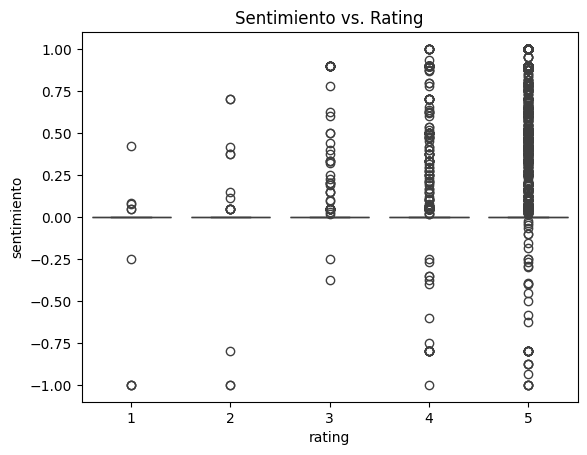

In [18]:
from textblob import TextBlob

# Función para calcular el sentimiento
def get_sentiment(text):
    analysis = TextBlob(text)
    return analysis.sentiment.polarity

# Añadir columna de sentimiento
comentarios['sentimiento'] = comentarios['comentario'].astype(str).apply(get_sentiment)

# Resumen de los sentimientos
print(comentarios['sentimiento'].describe())

# Comparar sentimiento con rating
import seaborn as sns
import matplotlib.pyplot as plt

sns.boxplot(x='rating', y='sentimiento', data=comentarios)
plt.title('Sentimiento vs. Rating')
plt.show()


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/mariolamas/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


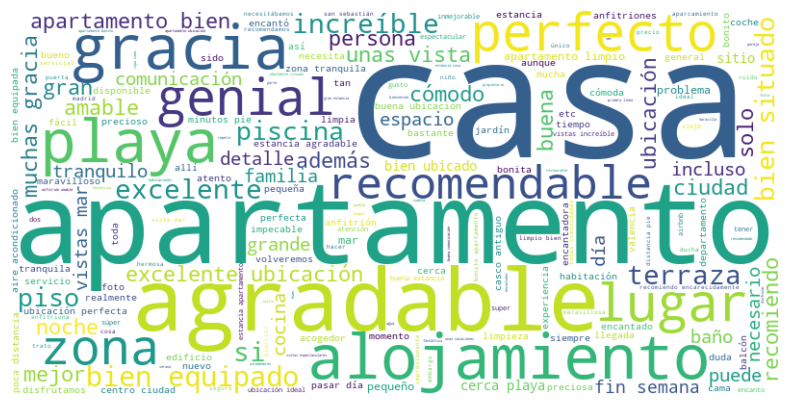

In [19]:
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import re

# Preprocesamiento del texto
nltk.download('stopwords')
stop_words = set(stopwords.words('spanish'))

def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'\W', ' ', text)
    text = re.sub(r'\d', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

comentarios['text_clean'] = comentarios['comentario'].astype(str).apply(preprocess_text)
comentarios['tokens'] = comentarios['text_clean'].apply(nltk.word_tokenize)
comentarios['tokens'] = comentarios['tokens'].apply(lambda x: [word for word in x if word not in stop_words])
comentarios['text_clean'] = comentarios['tokens'].apply(lambda x: ' '.join(x))

# Generar la nube de palabras
all_words = ' '.join([text for text in comentarios['text_clean']])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_words)

# Mostrar la nube de palabras
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


In [20]:
from gensim import corpora, models

# Crear diccionario y corpus
dictionary = corpora.Dictionary(comentarios['tokens'])
corpus = [dictionary.doc2bow(tokens) for tokens in comentarios['tokens']]

# Entrenar el modelo LDA
lda_model = models.LdaModel(corpus, num_topics=5, id2word=dictionary, passes=15)

# Mostrar los tópicos
for idx, topic in lda_model.print_topics(-1):
    print(f'Topic {idx}: {topic}')


ImportError: cannot import name 'triu' from 'scipy.linalg' (/Users/mariolamas/anaconda3/envs/socialnetwork/lib/python3.12/site-packages/scipy/linalg/__init__.py)

In [ ]:
%pip install --upgrade scipy

  Using cached scipy-1.14.0-cp312-cp312-macosx_14_0_x86_64.whl.metadata (60 kB)
Using cached scipy-1.14.0-cp312-cp312-macosx_14_0_x86_64.whl (25.6 MB)
  Attempting uninstall: scipy
    Found existing installation: scipy 1.13.1
    Uninstalling scipy-1.13.1:
      Successfully uninstalled scipy-1.13.1
Note: you may need to restart the kernel to use updated packages.


In [26]:
comentarios.rename(columns={'apart_id':'URL'},inplace=True)


In [27]:
set(apartamentos['URL'].unique()).intersection(set(comentarios['URL'].unique()))

{'https://www.airbnb.es/rooms/1002972535800788716?adults=1&category_tag=Tag%3A4104&children=0&enable_m3_private_room=true&infants=0&pets=0&photo_id=1774685273&search_mode=flex_destinations_search&check_in=2024-04-04&check_out=2024-04-09&source_impression_id=p3_1710967204_CG4ikOYnz%2BY29WU3&previous_page_section_name=1000',
 'https://www.airbnb.es/rooms/1008360725939823106?adults=1&category_tag=Tag%3A789&children=0&enable_m3_private_room=true&infants=0&pets=0&photo_id=1792019261&search_mode=flex_destinations_search&check_in=2024-04-03&check_out=2024-04-08&source_impression_id=p3_1710967158_L4%2FL%2BL0rhKGYQdt0&previous_page_section_name=1000',
 'https://www.airbnb.es/rooms/1026750185959859802?adults=1&category_tag=Tag%3A789&children=0&enable_m3_private_room=true&infants=0&pets=0&photo_id=1782595754&search_mode=flex_destinations_search&check_in=2024-04-06&check_out=2024-04-11&source_impression_id=p3_1710967167_MhZ%2F3SgtrH7s4rsk&previous_page_section_name=1000',
 'https://www.airbnb.es/r

In [28]:
comentarios.head()

,Unnamed: 0,name,imagen,user_id,comentario,URL,ubicacion,gender,rating,sentimiento,text_clean,tokens,problemas
0,0,Pierrick,https://a0.muscache.com/im/pictures/user/User-...,-1944082346885724092,"Muy buen recibimiento, alojamiento muy limpio ...",https://www.airbnb.es/rooms/37584336?adults=1&...,Lleva 8 años en Airbnb,male,5,1.0,buen recibimiento alojamiento limpio cerca tod...,"[buen, recibimiento, alojamiento, limpio, cerc...","{'ruido': 0, 'limpieza': 0, 'ubicación': 0, 'w..."
1,1,Harvey,https://a0.muscache.com/im/pictures/user/77bf6...,-875489624484136257,Apartamento moderno y limpio en una ubicación ...,https://www.airbnb.es/rooms/37584336?adults=1&...,Lleva 8 años en Airbnb,male,5,0.0,apartamento moderno limpio ubicación estupenda,"[apartamento, moderno, limpio, ubicación, estu...","{'ruido': 0, 'limpieza': 0, 'ubicación': 1, 'w..."
2,2,Kathy,https://a0.muscache.com/im/pictures/user/c4b01...,7379949921758826728,"Estuvimos muy agusto, el piso está muy cerca d...",https://www.airbnb.es/rooms/37584336?adults=1&...,Lleva 9 años en Airbnb,female,4,0.0,agusto piso cerca playa centro calpe igual ve ...,"[agusto, piso, cerca, playa, centro, calpe, ig...","{'ruido': 0, 'limpieza': 0, 'ubicación': 0, 'w..."
3,3,Marco,https://a0.muscache.com/im/pictures/user/e8d94...,-840522798083645344,Anfitrión muy amable y apartamento limpio en l...,https://www.airbnb.es/rooms/37584336?adults=1&...,Lleva 7 años en Airbnb,male,5,0.0,anfitrión amable apartamento limpio ubicación ...,"[anfitrión, amable, apartamento, limpio, ubica...","{'ruido': 0, 'limpieza': 0, 'ubicación': 1, 'w..."
4,4,Dan,https://a0.muscache.com/im/pictures/user/3a227...,-968160101397633662,Disfrutamos de nuestra estancia en este aparta...,https://www.airbnb.es/rooms/37584336?adults=1&...,"Phoenix, Arizona",male,5,0.0,disfrutamos estancia apartamento espacioso lim...,"[disfrutamos, estancia, apartamento, espacioso...","{'ruido': 0, 'limpieza': 0, 'ubicación': 0, 'w..."


                    ID     Titulo                        Descripcion Simple  \
0  5375220911806434689  Melior-1E  Alojamiento entero: piso en Calp, España   
1  5375220911806434689  Melior-1E  Alojamiento entero: piso en Calp, España   
2  5375220911806434689  Melior-1E  Alojamiento entero: piso en Calp, España   
3  5375220911806434689  Melior-1E  Alojamiento entero: piso en Calp, España   
4  5375220911806434689  Melior-1E  Alojamiento entero: piso en Calp, España   

   Evaluaciones  Tipo  Precio  \
0           8.0   2.0    83.0   
1           8.0   2.0    83.0   
2           8.0   2.0    83.0   
3           8.0   2.0    83.0   
4           8.0   2.0    83.0   

                                                 URL  Limpieza  Veracidad  \
0  https://www.airbnb.es/rooms/37584336?adults=1&...       4.9        4.5   
1  https://www.airbnb.es/rooms/37584336?adults=1&...       4.9        4.5   
2  https://www.airbnb.es/rooms/37584336?adults=1&...       4.9        4.5   
3  https://www.air

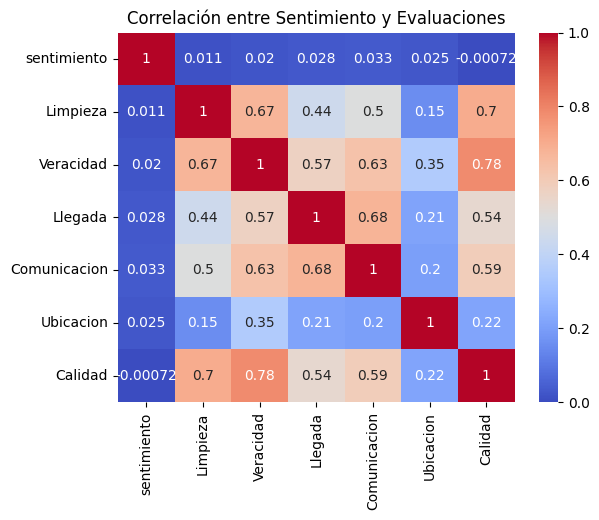

In [29]:

df_merged = pd.merge(apartamentos, comentarios, on='URL')
print(df_merged.head())
# Calcular la correlación
correlation_matrix = df_merged[['sentimiento', 'Limpieza', 'Veracidad', 'Llegada', 'Comunicacion', 'Ubicacion', 'Calidad']].corr()
print(correlation_matrix)

# Mostrar la matriz de correlación
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlación entre Sentimiento y Evaluaciones')
plt.show()


### **Relacion comentarios-Precio**

sentimiento
(-1.002, -0.6]    106.888889
(-0.6, -0.2]      233.750000
(-0.2, 0.2]       133.723770
(0.2, 0.6]        138.279621
(0.6, 1.0]        139.742890
Name: Precio, dtype: float64


/var/folders/4f/gbmqzwn51yg8gh7yyxzgpcl80000gn/T/ipykernel_2511/3485966945.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  precio_sentimiento = df_merged.groupby(pd.cut(df_merged['sentimiento'], bins=5))['Precio'].mean()


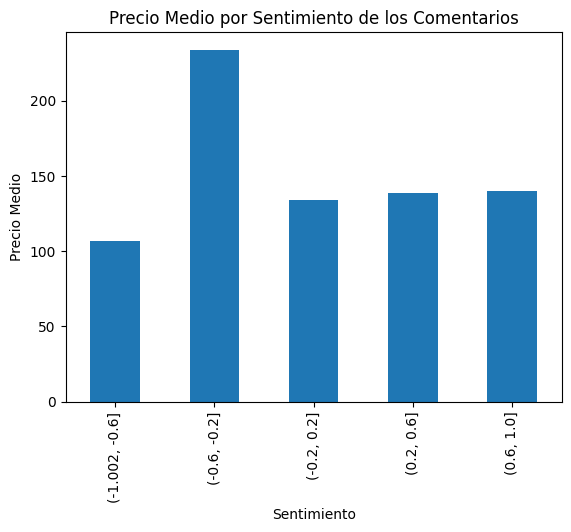

In [30]:
# Calcular el precio medio por sentimiento
precio_sentimiento = df_merged.groupby(pd.cut(df_merged['sentimiento'], bins=5))['Precio'].mean()

# Mostrar el precio medio por sentimiento
print(precio_sentimiento)

# Graficar el precio medio por sentimiento
precio_sentimiento.plot(kind='bar')
plt.title('Precio Medio por Sentimiento de los Comentarios')
plt.xlabel('Sentimiento')
plt.ylabel('Precio Medio')
plt.show()


### **Identificacion de problemas comunes**

ubicación    3444
limpieza      501
ruido         379
wifi          211
baños         177
parking       103
dtype: int64


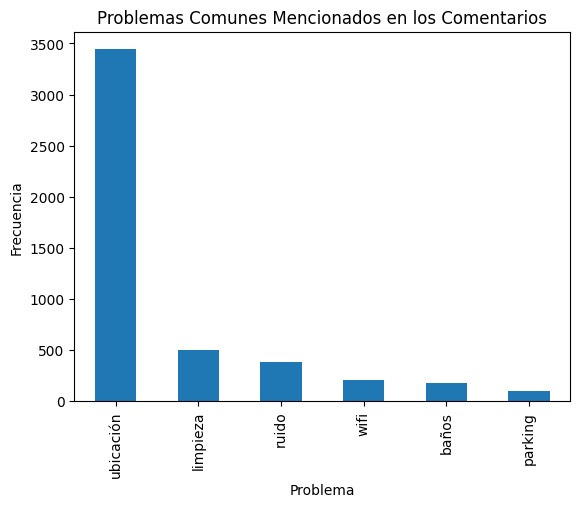

In [31]:
# Crear una lista de problemas comunes a buscar en los comentarios
problemas_comunes = ['ruido', 'limpieza', 'ubicación', 'wifi', 'parking', 'baños']

# Crear una función para contar la aparición de cada problema en los comentarios
def contar_problemas(text, problemas):
    contador = {problema: text.count(problema) for problema in problemas}
    return contador

# Aplicar la función a los comentarios
comentarios['problemas'] = comentarios['text_clean'].apply(lambda x: contar_problemas(x, problemas_comunes))

# Convertir la columna de problemas a un DataFrame separado
problemas_df = comentarios['problemas'].apply(pd.Series).sum().sort_values(ascending=False)
print(problemas_df)

# Graficar los problemas más comunes
problemas_df.plot(kind='bar')
plt.title('Problemas Comunes Mencionados en los Comentarios')
plt.xlabel('Problema')
plt.ylabel('Frecuencia')
plt.show()


        count      mean       std  min  25%  50%  75%  max
Tipo                                                      
0.0    3730.0  0.077397  0.229121 -1.0  0.0  0.0  0.0  1.0
2.0   11545.0  0.071276  0.226714 -1.0  0.0  0.0  0.0  1.0


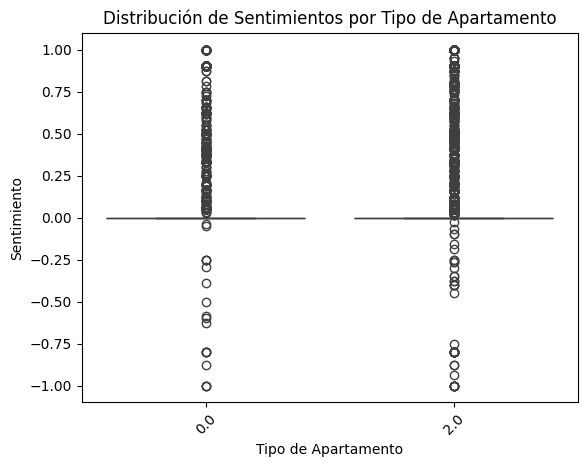

      Limpieza  Veracidad   Llegada  Comunicacion  Ubicacion   Calidad
Tipo                                                                  
0.0   4.741697   4.832319  4.894369      4.896661   4.758064  4.732106
2.0   4.755902   4.846870  4.861258      4.881712   4.893157  4.702236


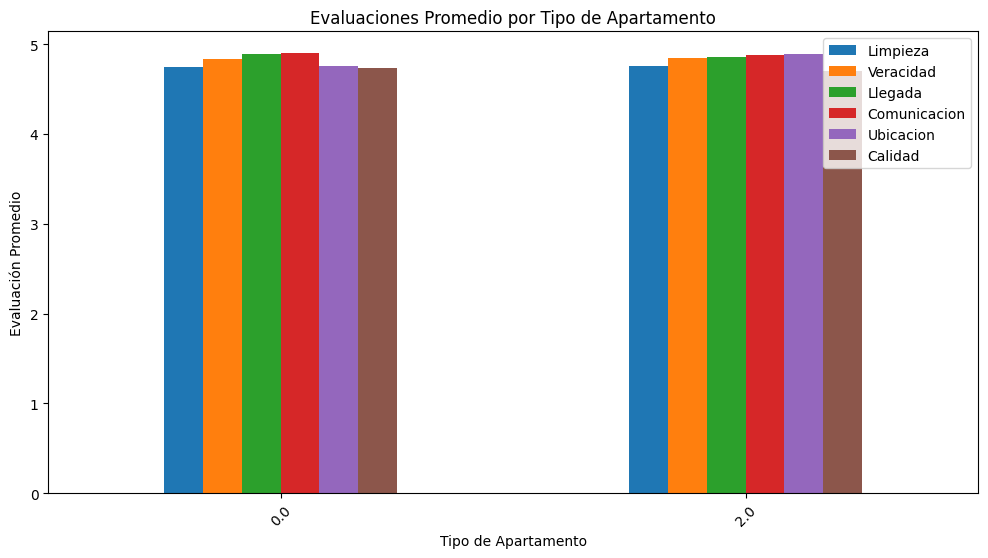

In [32]:
# Unir datasets
merged_df = pd.merge(comentarios, apartamentos, on='URL')

# Agrupar por tipo de apartamento y calcular estadísticas descriptivas de los sentimientos
tipo_sentimiento = merged_df.groupby('Tipo')['sentimiento'].describe()
print(tipo_sentimiento)

# Graficar la distribución de sentimientos por tipo de apartamento
sns.boxplot(x='Tipo', y='sentimiento', data=merged_df)
plt.title('Distribución de Sentimientos por Tipo de Apartamento')
plt.xlabel('Tipo de Apartamento')
plt.ylabel('Sentimiento')
plt.xticks(rotation=45)
plt.show()

# Calcular la media de las evaluaciones por tipo de apartamento
tipo_evaluaciones = merged_df.groupby('Tipo')[['Limpieza', 'Veracidad', 'Llegada', 'Comunicacion', 'Ubicacion', 'Calidad']].mean()
print(tipo_evaluaciones)

# Graficar las evaluaciones por tipo de apartamento
tipo_evaluaciones.plot(kind='bar', figsize=(12, 6))
plt.title('Evaluaciones Promedio por Tipo de Apartamento')
plt.xlabel('Tipo de Apartamento')
plt.ylabel('Evaluación Promedio')
plt.legend(loc='upper right')
plt.xticks(rotation=45)
plt.show()


In [33]:
import folium
# 
# Crear un mapa de folium centrado en una ubicación media
map_center = [df_merged['Latitud'].mean(), df_merged['Longitud'].mean()]
mapa = folium.Map(location=map_center, zoom_start=12)

# Añadir marcadores para cada apartamento
for idx, row in merged_df.iterrows():
    folium.Marker([row['Latitud'], row['Longitud']],
                  popup=f"Sentimiento: {row['sentimiento']}, Evaluación: {row['rating']}",
                  tooltip=row['Titulo']).add_to(mapa)

# Mostrar el mapa
mapa.save('mapa_apartamentos.html')
